## Categorizer / Classifier Part B

#### Applichiamo gli alberi di classificazione per risolvere il problema, dopo aver costruito l'input dataframe

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
#from sklearn.calibration import calibration_curve
#from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option('display.max_rows', 5)
pd.reset_option('display.max_rows')


In [11]:
data = pd.read_csv('merged_data.csv', encoding='latin1')
data = data.iloc[:,[0,1,4,5,6,7,8,9,10,11,12,13,14]]

In [12]:
pd.set_option('display.max_rows', None)
res = set(data['information'])

In [23]:
data['information'] = data['information'].fillna('')

In [24]:
data.head()

,datapoint_name,dataset_name,categorical_counter,categorical_proportion,numvariable_counter,numvariable_proportion,textual_variables_counter,textual_proportion,date_counter,are_sorted_dates,label_type,label,information
0,animal-disease,data,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,animal condition classification dataset presen...
1,banking-dataset-classification,new_test,10,0.769231,3,0.230769,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
2,banking-dataset-classification,new_train,13,0.812500,3,0.187500,0,0.0,0,0,2,classification,revenue decline portuguese bank would like kno...
3,car-acceptability-classification-dataset,car,7,1.000000,0,0.000000,0,0.0,0,0,2,classification,car acceptability classification database deri...
4,cervical-cancer-risk-classification,kag_risk_factors_cervical_cancer,29,0.966667,1,0.033333,0,0.0,0,0,2,classification,cervical cancer risk factors biopsy dataset ob...


## Bilanciamento Categorie

In [25]:
# Supponiamo che tu abbia un DataFrame chiamato 'df' con due colonne: 'feature' e 'label'

# Conta il numero di righe per ogni categoria
counts = data['label'].value_counts()

# Crea un DataFrame vuoto per il nuovo dataset bilanciato
balanced_data = pd.DataFrame(columns=data.columns)
rows = 100
# Itera attraverso ogni categoria
for category in counts.index:
    # Se il numero di righe è superiore a 150, seleziona casualmente 150 righe
    if counts[category] > rows:
        sampled_rows = data[data['label'] == category].sample(n=rows, random_state=42)
    # Altrimenti, mantieni tutte le righe per quella categoria
    else:
        sampled_rows = data[data['label'] == category]
    
    # Aggiungi le righe campionate al nuovo dataset bilanciato
    balanced_data = pd.concat([balanced_data, sampled_rows])

# Ora balanced_df contiene il nuovo dataset bilanciato

## Funzioni per plottare grafico al  variare di n_trees e learning curve

In [26]:
def n_trees_error(X, y):
    n_estimators_values = range(1, 101, 5)
    # Lista per memorizzare gli errori medi
    mean_errors = []

    for n_est in n_estimators_values:
        model = RandomForestClassifier(n_estimators=n_est, random_state=42)
        errors = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Puoi scegliere la metrica di valutazione desiderata
        mean_errors.append(np.mean(errors))
    
    plt.figure(figsize=(8, 4))
    plt.plot(n_estimators_values, mean_errors, label='Average Accuracy', marker='o')
    plt.title('Accuracy Vs Number of Trees')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plotta una curva di apprendimento.
    
    Parameters:
        estimator: Modello di machine learning
        title: Titolo del grafico
        X: Features del dataset
        y: Target del dataset
        ylim: Limiti dell'asse y
        cv: Schema di cross-validation (default: Stratified K-Folds)
        n_jobs: Numero di processi da utilizzare per il calcolo (default: -1, utilizza tutti i processori disponibili)
        train_sizes: Array dei rapporti di dimensioni del training set da utilizzare
        
    Returns:
        Plot della curva di apprendimento
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Applicazione Automated del Machine Learning

In [30]:
#APPROCCIO MULTI
def ml_classifier_multi(input_data, input_cols, model, categories, result):
    c_data = input_data.copy()
    c_data = c_data[c_data['label'].isin(categories)].reset_index(drop=True) 
    #econding da string a numerico nelle categorie
    for i in range(0,len(c_data)):   
        if (c_data['label'][i] == 'classification'):
            c_data.loc[i, 'label'] = 0
        if (c_data['label'][i] == 'regression'):
            c_data.loc[i, 'label'] = 1
        if (c_data['label'][i] == 'clustering'):
            c_data.loc[i, 'label'] = 2
        if (c_data['label'][i] == 'nlp'):
            c_data.loc[i, 'label'] = 3
        if (c_data['label'][i] == 'time_series'):
            c_data.loc[i, 'label'] = 4
    
    
    X = c_data.loc[:, input_cols]
    y = c_data['label'].astype(int)
    
    #codifica la variabile testuale utilizzando TfidfVectorizer
    
    tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Modifica il numero di features secondo necessità
    X_text_tfidf = tfidf_vectorizer.fit_transform(X['information']).toarray()
    
    #concatena la rappresentazione numerica e quella testuale
    feature_names_numeric = input_cols[0:-1]
    feature_names_text = [f'text_{i}' for i in range(X_text_tfidf.shape[1])]
    X_combined = pd.concat([X[feature_names_numeric], pd.DataFrame(X_text_tfidf, columns=feature_names_text)], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, shuffle=True, random_state=42)
   
    #esporta i dataset train e test
    #X_train.to_csv('XY_Data'+ '/' + category +'/' + 'X_train.csv', index=False)
    #X_test.to_csv('XY_Data'+ '/' + category +'/' + 'X_test.csv', index=False)
    #y_train.to_csv('XY_Data'+ '/' + category +'/' + 'y_train.csv', index=False)
    #y_test.to_csv('XY_Data'+ '/' + category +'/' + 'y_test.csv', index=False)
    
    #errore random forest in funzione di n estimator
    n_trees_error(X_train, y_train)
    print('TEST Accuracy (RANDOM STATE = 42)')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", conf_matrix)
    
    result['expected'] = y_test
    result['predicted'] = y_pred
    
    
    #CROSS VALIDATION
    # Specifica il numero di fold per la cross-validation
    n_folds = 5  # Puoi regolare questo valore in base alle tue esigenze

    # Inizializza l'oggetto StratifiedKFold
    stratk_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_combined, y, cv=stratk_fold)
    # Stampa il classification report
    print()
    print('TEST CROSS VALIDATION folds = 5')
    print(classification_report(y, y_pred))
    #check overfitting
    plot_learning_curve(model, "curva", X_combined, y, cv=5)
        
    # Ottieni l'importanza delle features
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Stampa l'importanza delle features in ordine
    print("Importanza delle features:")
    numb = 0
    for f in range(X_combined.shape[1]):
        print(f"{X_combined.columns[indices[f]]}: {importances[indices[f]]}")
        numb = numb+1
        if(numb == 5):
            break


## Random Forest

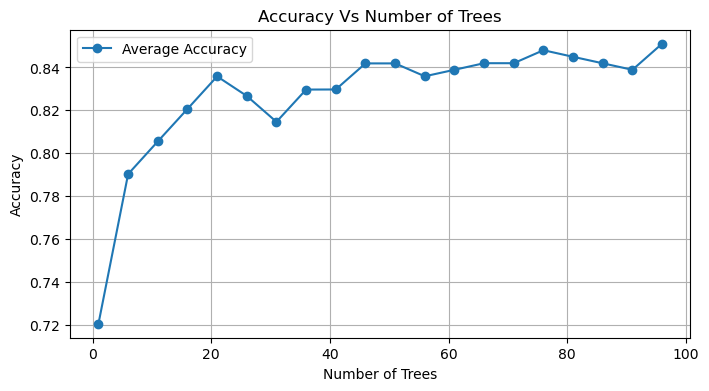

TEST Accuracy (RANDOM STATE = 42)
Accuracy: 0.8661971830985915
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75        26
           1       0.84      0.81      0.82        26
           2       0.78      0.82      0.80        22
           3       0.83      0.93      0.88        27
           4       0.98      1.00      0.99        41

    accuracy                           0.87       142
   macro avg       0.85      0.85      0.85       142
weighted avg       0.87      0.87      0.86       142

Confusion Matrix:
 [[18  4  3  1  0]
 [ 1 21  1  2  1]
 [ 2  0 18  2  0]
 [ 1  0  1 25  0]
 [ 0  0  0  0 41]]

TEST CROSS VALIDATION folds = 5
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        71
           1       0.81      0.79      0.80       100
           2       0.85      0.78      0.81       100
           3       0.84      0.97      0.90       100
          

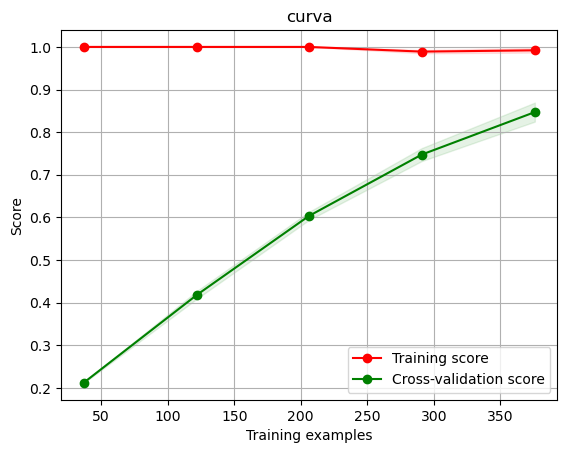

In [31]:
#risultato per vedere quali righe sbagliate e quali giuste nel dettaglio
result = pd.DataFrame(columns=['expected', 'predicted'])
#escludo la penultima colonna che è label
cols = data.columns[2:-2].append(pd.Index([data.columns[len(data.columns)-1]]))
cols = ['categorical_counter', 'categorical_proportion', 'numvariable_counter',
       'numvariable_proportion', 'textual_variables_counter',
       'textual_proportion', 'date_counter', 'are_sorted_dates',
       'information']
#cols = merged_data.columns[4:-2]
#print(cols)

model = RandomForestClassifier(n_estimators=40, random_state=42, max_depth=15)
#model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, min_samples_split=10, random_state=42)
data['information'].fillna('', inplace=True)
ml_classifier_multi(balanced_data, cols, model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)

#0 - classification
#1 - regression
#2 - clustering
#3 - nlp
#4 - time series

In [7]:
#Per vedere quali righe ha azzeccato e quali sbagliato nello specifico
result['expected']=result['expected'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result['predicted']=result['predicted'].replace({0: 'classification', 1: 'regression', 2: 'clustering', 
                                               3: 'nlp', 4: 'time_series'})
result.head()

,expected,predicted
610,time_series,time_series
821,time_series,time_series
290,nlp,nlp
799,time_series,time_series
168,clustering,clustering


## Gradient Boosting (con Grid Search)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform, randint

c_data = data.copy()
#c_data = c_data[c_data['label'].isin(categories)].reset_index(drop=True) 
#econding da string a numerico nelle categorie
for i in range(0,len(c_data)):   
    if (c_data['label'][i] == 'classification'):
        c_data.loc[i, 'label'] = 0
    if (c_data['label'][i] == 'regression'):
        c_data.loc[i, 'label'] = 1
    if (c_data['label'][i] == 'clustering'):
        c_data.loc[i, 'label'] = 2
    if (c_data['label'][i] == 'nlp'):
        c_data.loc[i, 'label'] = 3
    if (c_data['label'][i] == 'time_series'):
        c_data.loc[i, 'label'] = 4
    
    
X = c_data.loc[:, cols]
y = c_data['label'].astype(int)
    
#codifica la variabile testuale utilizzando TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Modifica il numero di features secondo necessità
X_text_tfidf = tfidf_vectorizer.fit_transform(X['information']).toarray()
    
#concatena la rappresentazione numerica e quella testuale
feature_names_numeric = cols[0:-1]
feature_names_text = [f'text_{i}' for i in range(X_text_tfidf.shape[1])]
X_combined = pd.concat([X[feature_names_numeric], pd.DataFrame(X_text_tfidf, columns=feature_names_text)], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, shuffle=True, random_state=42)
    
# Definizione dello spazio dei parametri
param_grid = {
    'learning_rate': [0.02, 0.05, 0.1],  # Tasso di apprendimento
    'n_estimators': [50, 100, 150],      # Numero di alberi
    'max_depth': [5, 10, 15],           # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10]    # Minimo numero di campioni per suddividere un nodo
}

# Inizializzazione del classificatore Gradient Boosting
gb_classifier = GradientBoostingClassifier()

# Creazione dell'oggetto RandomizedSearchCV per la ricerca casuale
random_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, 
                                   cv=5, scoring='accuracy')
#print('arrivato a random')
# Esecuzione della ricerca casuale sui dati di addestramento
random_search.fit(X_train, y_train)

# Visualizzazione dei migliori parametri e delle prestazioni del modello
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)


Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 150}
Best accuracy found:  0.8953138815207782


['categorical_counter', 'categorical_proportion', 'numvariable_counter', 'numvariable_proportion', 'textual_variables_counter', 'textual_proportion', 'date_counter', 'are_sorted_dates', 'information']


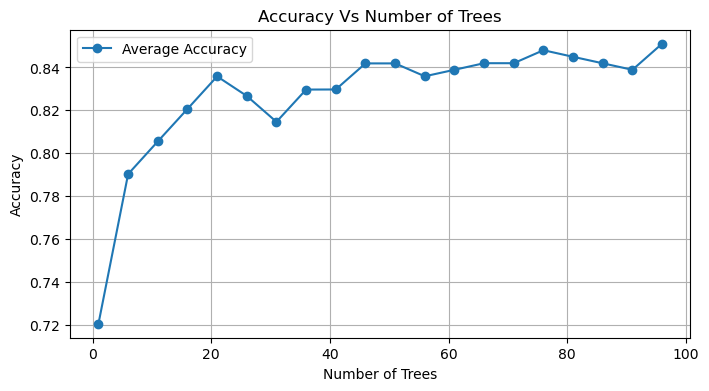

TEST Accuracy (RANDOM STATE = 42)
Accuracy: 0.8661971830985915
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75        26
           1       0.84      0.81      0.82        26
           2       0.78      0.82      0.80        22
           3       0.83      0.93      0.88        27
           4       0.98      1.00      0.99        41

    accuracy                           0.87       142
   macro avg       0.85      0.85      0.85       142
weighted avg       0.87      0.87      0.86       142

Confusion Matrix:
 [[18  4  3  1  0]
 [ 1 21  1  2  1]
 [ 2  0 18  2  0]
 [ 1  0  1 25  0]
 [ 0  0  0  0 41]]

TEST CROSS VALIDATION folds = 5
              precision    recall  f1-score   support

           0       0.81      0.77      0.79        71
           1       0.81      0.79      0.80       100
           2       0.85      0.78      0.81       100
           3       0.84      0.97      0.90       100
          

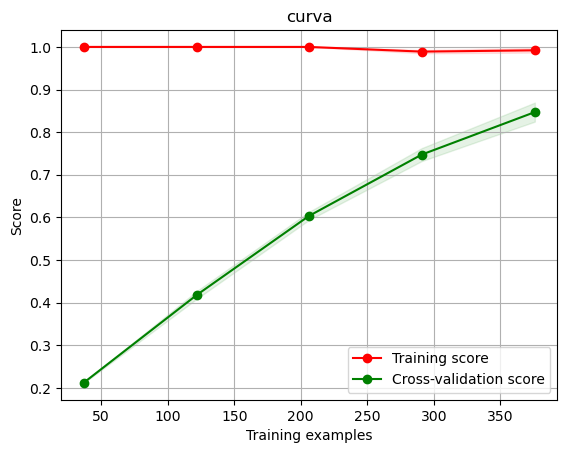

In [33]:
result = pd.DataFrame(columns=['expected', 'predicted'])
#escludo la penultima colonna che è label
cols = data.columns[2:-2].append(pd.Index([data.columns[len(data.columns)-1]]))
cols = ['categorical_counter', 'categorical_proportion', 'numvariable_counter',
       'numvariable_proportion', 'textual_variables_counter',
       'textual_proportion', 'date_counter', 'are_sorted_dates',
       'information']
#cols = merged_data.columns[4:-2]
print(cols)

model = RandomForestClassifier(n_estimators=40, random_state=42, max_depth=15)
#model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
data['information'].fillna('', inplace=True)
ml_classifier_multi(balanced_data, cols, model, ['classification', 'regression', 'nlp', 'clustering', 'time_series'], result)